In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
import tensorflow as tf
import transformers
from transformers import TFBertForTokenClassification
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import ABSATokenizer, convert_examples_to_tf_dataset, read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils
import utils.postprocessing_utils as post_utils

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Transfer Loss](#A1)

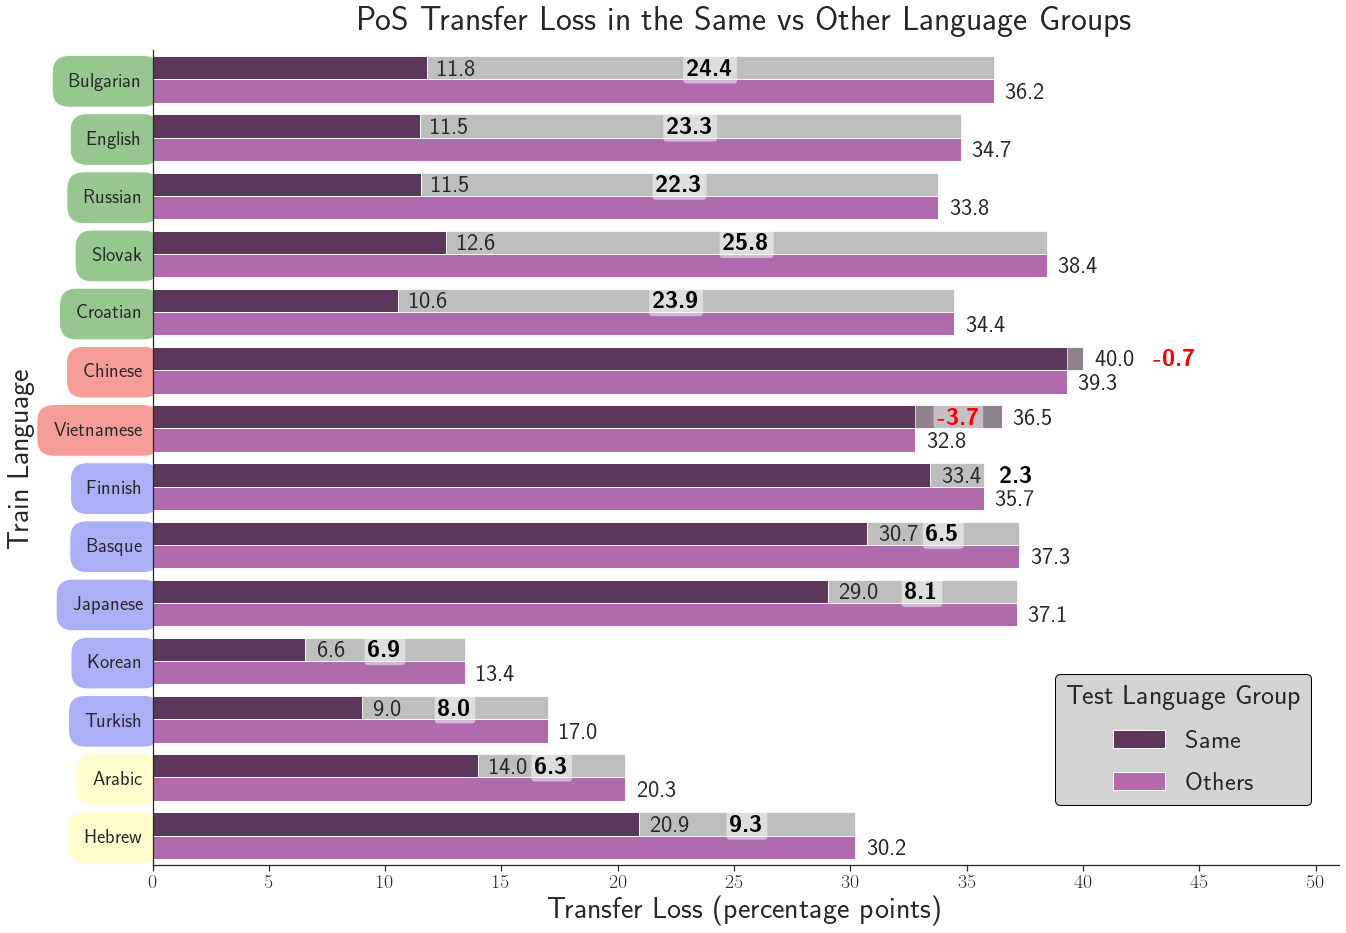

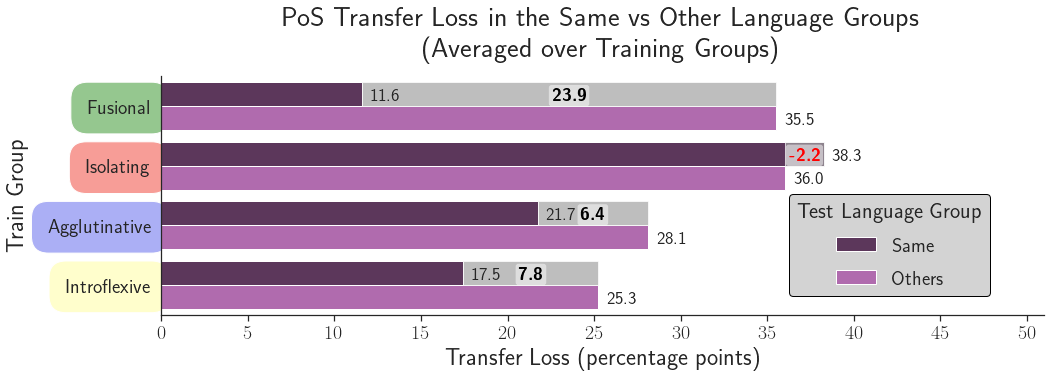

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Transfer Loss

In [34]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
langvlang = results["Accuracy"]["langvlang"]
langvgroup = results["Accuracy"]["langvgroup"]

In [35]:
df = pd.DataFrame({"Train-Group": langvlang.iloc[:15, 0], "Train-Language": langvlang.columns[2:-1], 
                   "Within-Accuracy": np.diagonal(langvlang.iloc[:15, 2:-1].values)})

In [36]:
df_group = langvgroup.iloc[:4, [True] + [False] + [True]*15 + [False]]

In [37]:
df_group = pd.melt(df_group.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Accuracy")

In [38]:
transfer = pd.merge(df, df_group, on="Train-Language")
transfer = transfer[transfer["Train-Language"] != "Thai"].reset_index(drop=True)
transfer["Cross-Accuracy"] = transfer["Cross-Accuracy"].astype(float) * 100
transfer["Within-Accuracy"] = transfer["Within-Accuracy"].astype(float) * 100

In [39]:
transfer["Transfer-Loss"] = transfer["Within-Accuracy"] - transfer["Cross-Accuracy"]

In [40]:
transfer.head()

,Train-Group,Train-Language,Within-Accuracy,Test-Group,Cross-Accuracy,Transfer-Loss
0,Fusional,Bulgarian,98.772577,Fusional,86.987853,11.784724
1,Fusional,Bulgarian,98.772577,Isolating,54.722207,44.050370
2,Fusional,Bulgarian,98.772577,Agglutinative,64.134517,34.638060
3,Fusional,Bulgarian,98.772577,Introflexive,68.986908,29.785669
4,Fusional,English,95.924391,Fusional,84.446718,11.477673


In [41]:
final = transfer[transfer["Test-Group"] != transfer["Train-Group"]].groupby(by=["Train-Group", "Train-Language"], 
                                                                    as_index=False, sort=False).mean()
final["Test-Group"] = "Others"

In [42]:
temp = transfer[transfer["Test-Group"] == transfer["Train-Group"]].copy()
temp.loc[:, "Test-Group"] = "Same"

In [43]:
final = pd.concat([final, temp], ignore_index=True)
final["sort"] = np.concatenate((np.arange(1, 28, 2), np.arange(0, 28, 2)))

In [44]:
final = final.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)

In [45]:
final.head()

,Train-Group,Train-Language,Within-Accuracy,Cross-Accuracy,Transfer-Loss,Test-Group
0,Fusional,Bulgarian,98.772577,86.987853,11.784724,Same
1,Fusional,Bulgarian,98.772577,62.614544,36.158033,Others
2,Fusional,English,95.924391,84.446718,11.477673,Same
3,Fusional,English,95.924391,61.179540,34.744851,Others
4,Fusional,Russian,96.326910,84.801907,11.525003,Same


In [46]:
final["Relative-Transfer-Loss"] = final["Transfer-Loss"] / final["Within-Accuracy"]

In [47]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

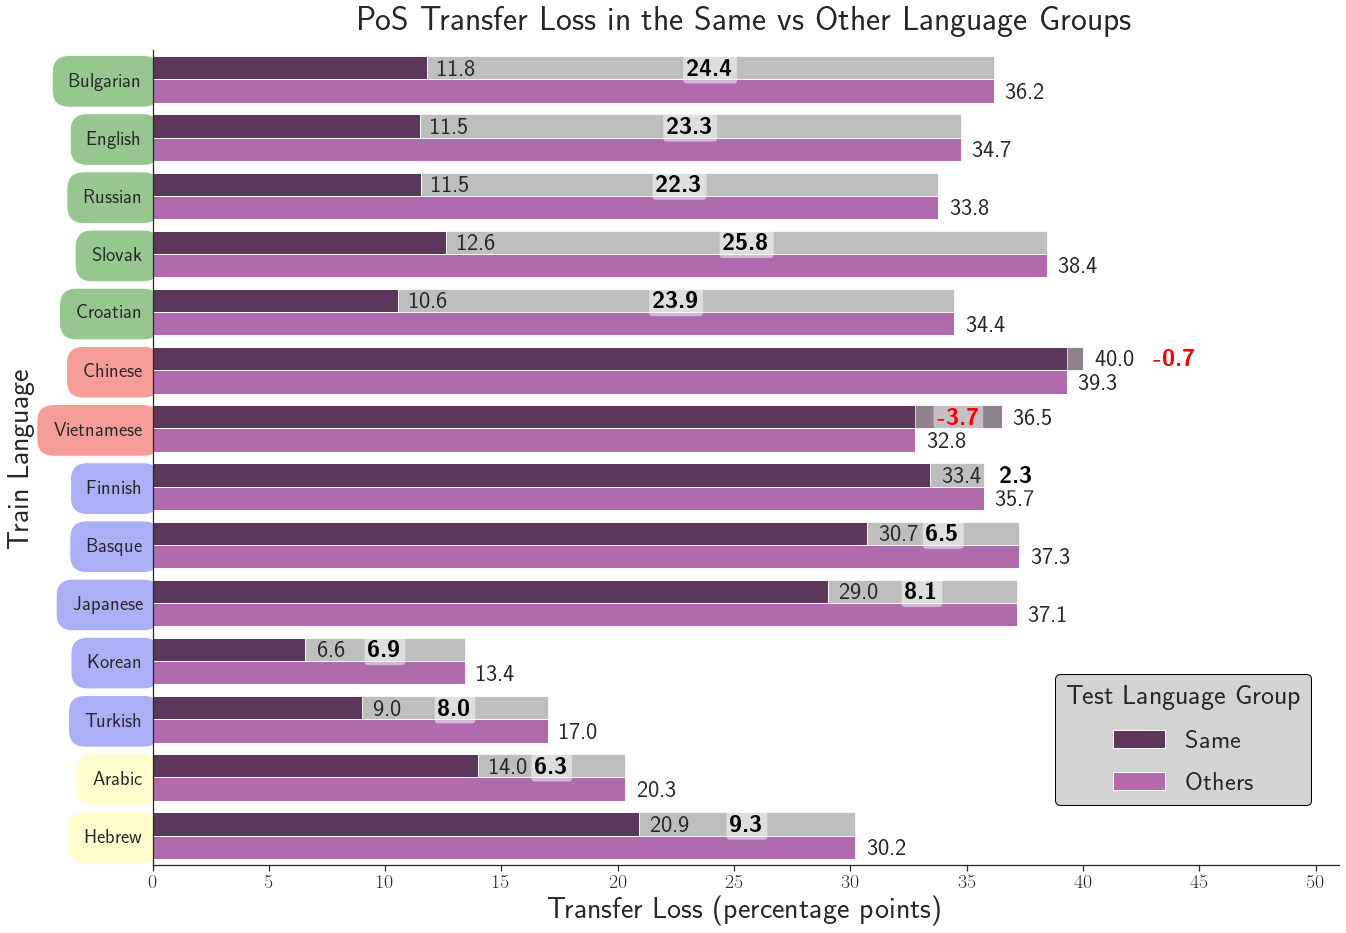

In [48]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [5, 2, 5, 2])]).sum()
extra_fontsize = 6

g = sns.catplot(
    data=final, kind="bar", x="Transfer-Loss", y="Train-Language", hue="Test-Group",
    height=12, aspect=1.5, palette=bar_colors, saturation=0.3, legend=False
)

langs = final["Train-Language"].unique().tolist()

for lang in langs:
    values = final.loc[(final["Train-Language"] == lang), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final.index[final["Train-Language"] == lang]):
        p = "{:.1f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], langs.index(lang) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if np.abs(diff) <= 3:
        align = "left"
        x = values[0] + 3
    if diff < 0:
        color = "red"
    g.ax.text(x, langs.index(lang) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.1f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.75, 0.25), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 51))
plt.xticks(range(0, 51, 5))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss (percentage points)", fontsize=24 +  extra_fontsize)
plt.title("PoS Transfer Loss in the Same vs Other Language Groups", fontsize=28 +  extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_transfer_loss_all.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [49]:
final_avg = final.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()

In [50]:
final_avg

,Train-Group,Test-Group,Within-Accuracy,Cross-Accuracy,Transfer-Loss,Relative-Transfer-Loss
0,Fusional,Same,97.002628,85.405269,11.597359,0.119576
1,Fusional,Others,97.002628,61.487431,35.515197,0.366131
2,Isolating,Same,89.799704,51.536688,38.263016,0.425870
3,Isolating,Others,89.799704,53.764677,36.035027,0.400639
4,Agglutinative,Same,84.830319,63.086677,21.743642,0.240434
5,Agglutinative,Others,84.830319,56.715432,28.114887,0.319247
6,Introflexive,Same,86.842822,69.386161,17.456661,0.199095
7,Introflexive,Others,86.842822,61.590299,25.252523,0.288067


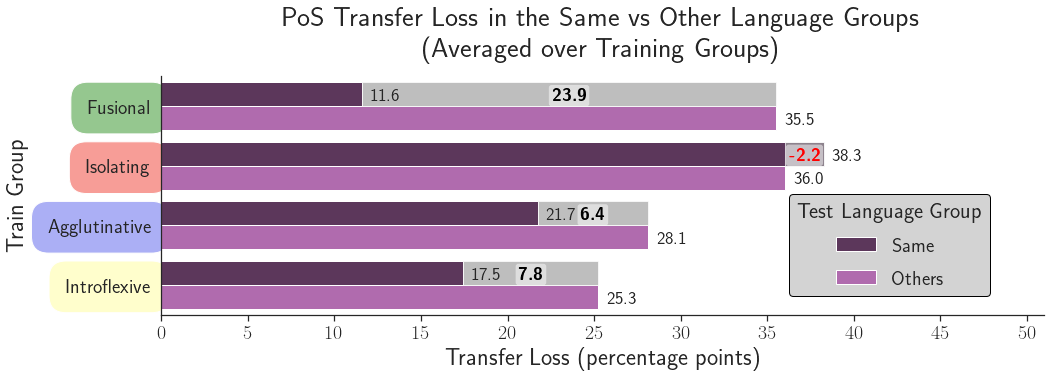

In [51]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
extra_fontsize = 0

g = sns.catplot(
    data=final_avg, kind="bar", x="Transfer-Loss", y="Train-Group", hue="Test-Group",
    height=4, aspect=3.5, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final_avg.index[final_avg["Train-Group"] == group]):
        p = "{:.1f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], groups.index(group) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if diff < 0:
        color = "red"
    g.ax.text(x, groups.index(group) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.1f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.55), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 51))
plt.xticks(range(0, 51, 5))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss (percentage points)", fontsize=24 +  extra_fontsize)
plt.title("PoS Transfer Loss in the Same vs Other Language Groups \n (Averaged over Training Groups)", 
          fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_transfer_loss_groups.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

Relative transfer loss tells the same story

In [195]:
final_avg["Relative-Transfer-Loss"] = final_avg["Relative-Transfer-Loss"] * 100

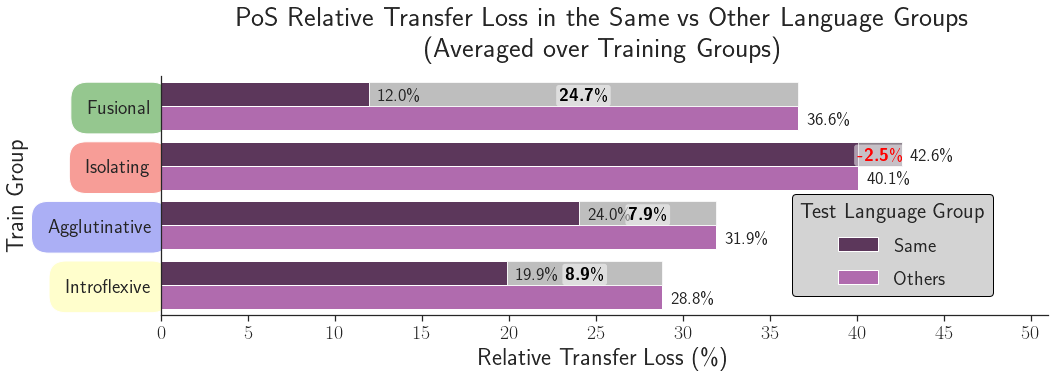

In [197]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
extra_fontsize = 0

g = sns.catplot(
    data=final_avg, kind="bar", x="Relative-Transfer-Loss", y="Train-Group", hue="Test-Group",
    height=4, aspect=3.5, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Relative-Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final_avg.index[final_avg["Train-Group"] == group]):
        p = "{:.1f}\%".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], groups.index(group) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if diff < 0:
        color = "red"
    g.ax.text(x, groups.index(group) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.1f}}}\%".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.55), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 51))
plt.xticks(range(0, 51, 5))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Relative Transfer Loss (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Relative Transfer Loss in the Same vs Other Language Groups \n (Averaged over Training Groups)", 
          fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_relative_transfer_loss_groups.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()